In [12]:
import numpy as np
import pandas as pd
import torch
import sys
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('/home/benoit.sautydechalon/deformetrica')

from deformetrica.core.estimator_tools.samplers.srw_mhwg_sampler import SrwMhwgSampler
from deformetrica.core.estimators.gradient_ascent import GradientAscent
from deformetrica.core.estimators.mcmc_saem import McmcSaem
# Estimators
from deformetrica.core.estimators.scipy_optimize import ScipyOptimize
from deformetrica.core.model_tools.manifolds.exponential_factory import ExponentialFactory
from deformetrica.core.model_tools.manifolds.generic_spatiotemporal_reference_frame import GenericSpatiotemporalReferenceFrame
from deformetrica.core.models.longitudinal_metric_learning import LongitudinalMetricLearning
from deformetrica.core.models.model_functions import create_regular_grid_of_points
from deformetrica.in_out.array_readers_and_writers import read_2D_array
from deformetrica.in_out.dataset_functions import read_and_create_scalar_dataset, read_and_create_image_dataset
from deformetrica.support.probability_distributions.multi_scalar_normal_distribution import MultiScalarNormalDistribution
from deformetrica.support.utilities.general_settings import Settings
from deformetrica import estimate_longitudinal_metric_model
from deformetrica.in_out.array_readers_and_writers import *
from deformetrica.launch.estimate_longitudinal_metric_model import instantiate_longitudinal_metric_model
import deformetrica as dfca

import seaborn as sns

In [ ]:
path = 'tadpole/'
output_folder = 'output/'

## 1. Loading the individual parameters and raw data

In [115]:
rer = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__IndividualRandomEffectsSamples.npy', 
              allow_pickle=True)[()]
trajectories = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__Trajectory.npy',
       allow_pickle=True)[()]
ids = pd.read_csv(path+output_folder+'LongitudinalMetricModel_subject_ids_unique.txt', header=None).values

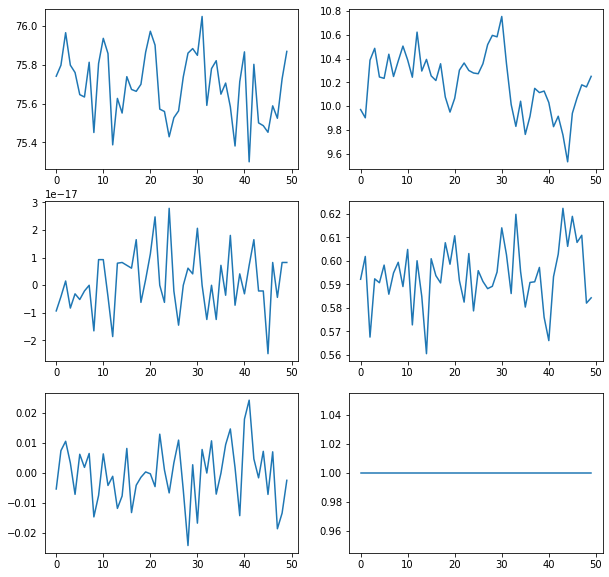

In [102]:
# Plot the non burn-in iterations
fig, axes = plt.subplots(3,2, figsize=(10,10))

axes[0][0].plot(rer['onset_age'].mean(axis=1))
axes[0][1].plot(rer['onset_age'].std(axis=1))
axes[1][0].plot(rer['log_acceleration'].mean(axis=1))
axes[1][1].plot(rer['log_acceleration'].std(axis=1))
axes[2][0].plot(rer['sources'].mean(axis=1))
axes[2][1].plot(rer['sources'].std(axis=1))

plt.show()

In [62]:
# Then in the required format for the deformetrica model

rer['onset_age'] = rer['onset_age'].mean(axis=0)
rer['log_acceleration'] = rer['log_acceleration'].mean(axis=0)
rer['sources'] = np.array([[source] for source in rer['sources'].mean(axis=0)])
averaged_rer = rer
averaged_rer

{'onset_age': array([ 96.3503807 ,  97.10032507,  69.52103783,  73.69770558,
         87.22543853,  86.16386943,  63.37203183,  55.66059291,
         68.17080044,  76.54366689,  87.60788503,  75.11964902,
         87.2553502 ,  83.61753676,  83.01393245,  81.65975476,
         76.20307935,  71.926339  ,  88.87674247,  65.7231705 ,
         70.45499951,  75.02677022,  76.27626305,  73.91451393,
         83.99924536,  75.84978381,  78.28030567,  72.71630306,
         66.69524911,  81.67219581,  64.09809849,  78.17526053,
         55.48046437,  80.70795929,  75.78284674,  70.93717518,
         84.94650863,  74.20748044,  56.9733308 ,  70.91386157,
         74.33448895,  82.99567144,  72.91201511,  66.57113248,
         61.87296663,  80.53916781,  67.16032144,  87.88383997,
         71.91800216,  81.20091625,  80.48389207,  79.64226808,
         81.98841876,  83.48704876,  81.67902221,  91.88868228,
         84.92402735,  84.96257637,  63.8168009 ,  83.14415816,
         80.08349221,  76.0

In [66]:
# First we put them in a dataframe for visualization purpose

ip = pd.DataFrame(columns=['tau','xi','source'], index=[int(idx[0]) for idx in ids])
ip['tau'] = rer['onset_age'].mean(axis=0)
ip['xi'] = rer['log_acceleration'].mean(axis=0)
ip['source'] = rer['sources'].mean(axis=1)

ip

ValueError: Length of values (50) does not match length of index (430)

In [116]:
tau = [tau[0] for tau in pd.read_csv(path+output_folder+'LongitudinalMetricModel_onset_ages.txt', header=None).values]
xi = [xi[0] for xi in pd.read_csv(path+output_folder+'LongitudinalMetricModel_log_accelerations.txt', header=None).values]
sources = [np.float(sources) for sources in pd.read_csv(path+output_folder+'LongitudinalMetricModel_sources.txt', header=None).values]

ip = pd.DataFrame(columns=['tau','xi','source'], index=[int(idx[0]) for idx in ids])

ip['tau'] = tau
ip['xi'] = xi
ip['source'] = sources

ip

/tmp/ipykernel_2270574/1755275170.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sources = [np.float(sources) for sources in pd.read_csv(path+output_folder+'LongitudinalMetricModel_sources.txt', header=None).values]


,tau,xi,source
3,61.432639,0.164084,-0.135234
4,64.460305,0.106747,0.481641
5,80.399463,-1.247760,-0.054991
6,77.437032,0.266354,0.847986
10,71.780770,-0.236618,1.632855
...,...,...,...
4989,85.743556,-0.656312,0.587627
5066,69.469092,-0.690720,-0.249059
5079,82.266332,-0.104291,-0.172894
5082,75.993014,0.227735,-1.415186


In [22]:
data = pd.DataFrame(index=[ids, times], columns=['adas_memory', 'hippocampus'])
data['adas_memory'] = adas_memory
data['hippocampus'] = hippocampus
data

adas_memory  hippocampus
4    74.868477     0.407333     0.377389
     75.075706     0.518444     0.375055
     75.282936     0.466667     0.364087
     75.490158     0.540667     0.382969
     76.111847     0.511111     0.429288
...                     ...          ...
1425 78.461342     0.540667     0.242699
     79.093491     0.607333     0.267690
1430 84.350166     0.577778     0.745385
     84.780472     0.659333     0.774981
     86.071396     0.770444     0.804698

[942 rows x 2 columns]

In [88]:
path = 'adni_study'
data = '/data_adni'

times = [time[0] for time in pd.read_csv(path+data+'/X.csv', header=None).values]
hip = [score[0] for score in pd.read_csv(path+data+'/Y_adas.csv', header=None).values]
ven = [score[1] for score in pd.read_csv(path+data+'/Y_adas.csv', header=None).values]
adas = [score[2] for score in pd.read_csv(path+data+'/Y_adas.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+data+'/group.csv', header=None).values]

In [89]:
data = pd.DataFrame(index=[ids, times], columns=['hip', 'ven', 'adas'])
data['hip'] = hip
data['ven'] = ven
data['adas'] = adas
data.index.set_names(['ID','TIME'], inplace=True)
data

hip       ven      adas
ID   TIME                                
21   77.640  0.377238  0.292681  0.096012
     78.647  0.412620  0.348860  0.162012
     79.630  0.380280  0.332652  0.036000
     80.649  0.439737  0.324140  0.167988
     82.694  0.431896  0.365129  0.162012
...               ...       ...       ...
5290 67.079  0.368073  0.092811  0.203988
     69.128  0.340166  0.159048  0.138000
     71.074  0.260959  0.217518  0.126012
     72.211  0.343376  0.198040  0.111000
     73.068  0.332413  0.215177  0.060012

[2673 rows x 3 columns]

In [41]:
times = [time[0] for time in pd.read_csv(path+'/simulated_data_1/X.csv', header=None).values]
logistic = [score[0] for score in pd.read_csv(path+'/simulated_data_1/Y.csv', header=None).values]
sum_logistic = [score[1] for score in pd.read_csv(path+'/simulated_data_1/Y.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+'/output_1/LongitudinalMetricModel_subject_ids.txt', header=None).values]

FileNotFoundError: [Errno 2] No such file or directory: 'adni_study/simulated_data_1/X.csv'

In [42]:
data = pd.DataFrame(index=[ids, times], columns=['logistic', 'sum_logistic'])
data['logistic'] = logistic
data['sum_logistic'] = sum_logistic
data

NameError: name 'logistic' is not defined

In [56]:
estimated_parameters = pd.read_csv(path+'/simulated_data_metric_1/estimated_parameters.csv').set_index('Unnamed: 0')
estimated_parameters.index.name = 'ID'
estimated_parameters.columns = ['tau', 'xi', 'source']

In [58]:
estimated_parameters

,tau,xi,source
ID,,,
0,68.358838,0.102351,[-1.13353786]
1,68.105130,0.054489,[0.26596968]
2,65.884906,-0.010095,[0.64330486]
3,66.382700,-0.031006,[0.90997858]
4,71.282323,-0.006042,[-0.42833421]
...,...,...,...
295,52.789910,0.359808,[0.91657408]
296,77.792713,0.079305,[0.5921584]
297,78.070537,0.063391,[-0.67612817]


In [59]:
abs(estimated_parameters[['tau','xi']]-individual_parameters[['tau','xi']]).describe()

,tau,xi
count,300.000000,300.000000
mean,5.225177,0.352680
std,6.200190,0.275182
min,0.008462,0.000296
25%,1.129697,0.137134
50%,2.820366,0.298099
75%,7.565926,0.523082
max,48.079072,1.273377


In [5]:
tau = [tau[0] for tau in pd.read_csv(path+'/preprocessing_test_2/2_gradient_descent_on_the_mode/LongitudinalMetricModel_onset_ages.txt', header=None).values]
xi = [xi[0] for xi in pd.read_csv(path+'/preprocessing_test_2/2_gradient_descent_on_the_mode/LongitudinalMetricModel_log_accelerations.txt', header=None).values]
sources = [np.float(sources) for sources in pd.read_csv(path+'/preprocessing_test_2/2_gradient_descent_on_the_mode/LongitudinalMetricModel_sources.txt', header=None).values]

individual_parameters_after_initialization = pd.DataFrame(columns=individual_parameters.columns, index=individual_parameters.index)
individual_parameters_after_initialization['tau'] = tau
individual_parameters_after_initialization['xi'] = xi
individual_parameters_after_initialization['source'] = sources

NameError: name 'individual_parameters' is not defined

In [44]:
tau = [tau[0] for tau in pd.read_csv(path+output_folder+'LongitudinalMetricModel_onset_ages.txt', header=None).values]
xi = [xi[0] for xi in pd.read_csv(path+output_folder+'LongitudinalMetricModel_log_accelerations.txt', header=None).values]
sources = [np.float(sources) for sources in pd.read_csv(path+output_folder+'LongitudinalMetricModel_sources.txt', header=None).values]

estimated_ip = pd.DataFrame(columns=individual_parameters.columns, index=individual_parameters.index)
estimated_ip['tau'] = tau
estimated_ip['xi'] = xi
estimated_ip['source'] = sources

FileNotFoundError: [Errno 2] No such file or directory: 'adni_studyoutput_adas_3f/LongitudinalMetricModel_onset_ages.txt'

In [32]:
path = 'mds_study'
times = [time[0] for time in pd.read_csv(path+'/output/LongitudinalMetricModel_absolute_times.txt', header=None).values]
mds1 = [score[0] for score in pd.read_csv(path+'/mds_data/MDS_values.csv', header=None).values]
mds2 = [score[1] for score in pd.read_csv(path+'/mds_data/MDS_values.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+'/output/LongitudinalMetricModel_subject_ids.txt', header=None).values]

In [33]:
data = pd.DataFrame(index=[ids, times], columns=['mds1', 'mds2'])
data['mds1'] = mds1
data['mds2'] = mds2
data

mds1      mds2
3001 59.910362  0.500000  0.133333
     59.982315  0.571429  0.133333
     60.215916  0.500000  0.133333
     60.449516  0.500000  0.200000
     60.683113  0.571429  0.200000
...                  ...       ...
3467 71.582550  0.500000  0.733333
     71.708649  0.714286  0.800000
     71.957832  0.357143  0.733333
     72.333115  0.357143  0.666667
     72.708397  0.357143  0.733333

[3000 rows x 2 columns]

In [35]:
reconstructed = pd.read_csv('mds_study/personalize_output/LongitudinalMetricModel_reconstructed_values.txt', sep=' ', header=None)
reconstructed.columns = ['mds1', 'mds2']
reconstructed.index = data.index

In [36]:
abs(reconstructed-data).describe()

,mds1,mds2
count,3000.000000,3000.000000
mean,0.163081,0.180404
std,0.134820,0.168752
min,0.000148,0.000094
25%,0.061791,0.060085
50%,0.131837,0.135601
75%,0.231493,0.250328
max,1.103094,2.036188


## 2. Evaluating the reconstruction error

In [27]:
path = 'adni_study'
args = {'verbosity':'INFO', 'output':'personalize',
        'model':path+'/model_adni.xml', 'dataset':path+'/data_set.xml', 'parameters':path+'/optimization_parameters_saem.xml'}


"""
Read xml files, set general settings, and call the adapted function.
"""

xml_parameters = dfca.io.XmlParameters()
xml_parameters.read_all_xmls(args['model'],
                             args['dataset'],
                             args['parameters'])

logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logger.setLevel(logging.INFO)

In [28]:
dataset = read_and_create_scalar_dataset(xml_parameters)
model, individual_RER = instantiate_longitudinal_metric_model(xml_parameters, logger, dataset, observation_type='scalar')

286 good iterations out of 287
234 good iterations out of 235


In [ ]:
onset_ages = torch.tensor(estimated_parameters['onset_age'])
log_accelerations = torch.tensor(estimated_parameters['log_acceleration'])
sources = torch.tensor([[float(source[1:-1])] for source in estimated_parameters['sources'].values])

In [45]:
v0, p0, metric_parameters, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(dataset.times, log_accelerations, onset_ages)

absolute_times_to_write = []
for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

#np.savetxt(os.path.join(Settings().output_dir, "LongitudinalMetricModel_absolute_times.txt"), np.array(absolute_times_to_write))

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, metric_parameters,
                                            modulation_matrix)

286 good iterations out of 287
234 good iterations out of 235


In [127]:
onset_ages

tensor([ 96.2934,  96.9299,  69.4830,  73.6413,  87.2677,  86.1613,  63.4117,
         55.7194,  68.1982,  76.5737,  87.7196,  75.1162,  87.1543,  83.6553,
         83.1533,  81.6693,  76.1817,  71.9192,  88.8557,  65.7251,  70.4608,
         75.0448,  76.2404,  73.8944,  84.1686,  75.8177,  78.1978,  72.7724,
         66.6949,  81.5363,  64.1281,  78.1320,  55.5190,  80.7385,  75.7416,
         70.8385,  84.9805,  74.1727,  57.0277,  70.9116,  74.2796,  82.8664,
         72.9421,  66.6120,  61.8696,  80.6121,  67.1708,  87.7129,  71.9011,
         81.1643,  80.4945,  79.5949,  81.9689,  83.4668,  81.6710,  91.9572,
         84.7684,  84.9700,  63.7370,  83.1986,  80.0570,  76.2026,  82.5469,
         65.9088,  67.7061,  76.3982,  85.0399,  77.8695,  74.4760,  71.3635,
         88.1181,  79.9953,  64.9888,  86.7840,  67.3133,  69.4561,  56.7981,
         81.6981,  79.7315,  83.0036,  89.0880,  67.0199,  77.4680,  71.5120,
         77.0790,  78.5055,  87.9939,  67.1971,  75.9513,  69.48

In [ ]:
# predictions = []
subject_ids = []
times = []

targets = dataset.deformable_objects

number_of_subjects = dataset.number_of_subjects
residuals = []

for i in range(number_of_subjects):
    predictions_i = []
    for j, t in enumerate(absolute_times[i]):
        if sources is not None:
            prediction = model.spatiotemporal_reference_frame.get_position(t, sources=sources[i])
        else:
            prediction = model.spatiotemporal_reference_frame.get_position(t)
        predictions_i.append(prediction.cpu().data.numpy())
        predictions.append(prediction.cpu().data.numpy())
        subject_ids.append(dataset.subject_ids[i])
        times.append(dataset.times[i][j])

    targets_i = targets[i].cpu().data.numpy()


In [47]:
predicted = data.copy()
predicted['hip'] = [prediction[0] for prediction in predictions]
predicted['ven'] = [prediction[1] for prediction in predictions]
predicted['adas'] = [prediction[2] for prediction in predictions]

In [32]:
predicted = data.copy()
predicted['logistic'] = [prediction[0] for prediction in predictions]
predicted['sum_logistic'] = [prediction[1] for prediction in predictions]

In [35]:
diff = predicted - data
abs(diff).describe()

,hip,ven,adas
count,2673.000000,2673.000000,2673.000000
mean,0.073730,0.049116,0.090701
std,0.056625,0.041559,0.084786
min,0.000044,0.000023,0.000017
25%,0.029189,0.017522,0.034008
50%,0.062356,0.038889,0.067731
75%,0.106451,0.069827,0.121959
max,0.356852,0.502059,0.735486


## Leaspy model

In [90]:
data['ID'], data['TIME'] = data.index.get_level_values(0), data.index.get_level_values(1)
data = data.set_index('ID')
individual_parameters = pd.read_csv('leapsy/joint_study_small_param.csv').set_index('ID')
individual_parameters.index = data.index.unique()
individual_parameters

,tau,xi,sources
ID,,,
21,85.623108,0.485074,-0.036556
56,87.378098,0.356685,-0.183288
69,67.445099,-0.305585,0.035441
377,72.936371,0.041512,-0.233056
413,85.360130,-0.119878,0.686009
...,...,...,...
5259,87.225395,-0.013813,-0.684990
5265,75.593620,1.042938,1.086733
5266,77.901566,0.329376,0.933305


## Visualization of tau/alpha correlations with diagnosis

In [117]:
diag = pd.read_csv('~/ADNI-analysis/longitudinal_study/data/ADNI_cog_full.csv',usecols=['ID', 'session_id', 'TIME', 'diagnosis']).set_index('ID')

In [118]:
sub_diag = pd.DataFrame(index=diag.index.unique(), columns=['diag', 'label'])

for sub in sub_diag.index:
    if type(diag.loc[sub]) == pd.core.series.Series:
        sub_diag.drop(sub)
    else:
        if 'AD' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'AD'
            sub_diag.loc[sub]['label'] = 2
        elif 'MCI' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'MCI'
            sub_diag.loc[sub]['label'] = 1
        else:
            sub_diag.loc[sub]['diag'] = 'CN'
            sub_diag.loc[sub]['label'] = 0


In [119]:
sub_diag

,diag,label
ID,,
295,CN,0
413,CN,0
559,CN,0
619,AD,2
685,CN,0
...,...,...
6570,CN,0
6574,CN,0
6575,CN,0


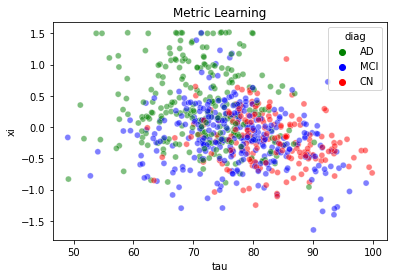

In [120]:
%matplotlib inline

sub_diag = sub_diag.loc[ip.index]
ip['diag'] = sub_diag['diag']
ip['label'] = sub_diag['label']

sns.scatterplot(data = ip,
                x = 'tau', 
                y = 'xi', 
                hue = 'diag',
                alpha=0.5, 
                palette = ['g', 'b', 'r'] )
plt.title('Metric Learning')
plt.show()

In [121]:
%matplotlib inline

sub_diag = sub_diag.loc[individual_parameters.index]
individual_parameters['diag'] = sub_diag['diag']
individual_parameters['label'] = sub_diag['label']

sns.scatterplot(data = individual_parameters,
                x = 'tau', 
                y = 'xi', 
                hue = 'diag',
                alpha=0.5, 
                palette = ['g', 'b', 'r'])
plt.title('Leaspy')
plt.show()

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Int64Index([2052, 2060, 2083, 2100, 2116,\n            ...\n            5259, 5265, 5266, 5289, 5290],\n           dtype='int64', name='ID', length=167). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [122]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

colors = ['green', 'blue', 'red']
labels = ['CN', 'MCI', 'AD']
data = ip

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.2)
        ax.add_artist(ell)

In [123]:
from sklearn.model_selection import KFold

X, y = ip[['tau', 'xi']].values, ip['label']

train_total, test_total = [], []

for i in range(100):
    train_split, test_split = 0, 0
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(X)

    y = np.array(y)

    for train_index, test_index in kf.split(X):

        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

        n_classes = len(np.unique(y_train))

        estimator = GaussianMixture(n_components=n_classes, covariance_type='full', max_iter=100, random_state=0)
        estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                        for i in range(n_classes)])

        # Train the other parameters using the EM algorithm.
        estimator.fit(X_train)

        y_train_pred = estimator.predict(X_train)
        train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
        train_split += train_accuracy

        y_test_pred = estimator.predict(X_test)
        test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
        test_split += test_accuracy
    
    train_total.append(train_split/5)
    test_total.append(test_split/5)

print(np.array(train_total).mean(), np.array(test_total).mean())
print(np.array(train_total).std(), np.array(test_total).std())

50.6547619047619 50.36734693877551
0.8474559932051157 1.22176567731394


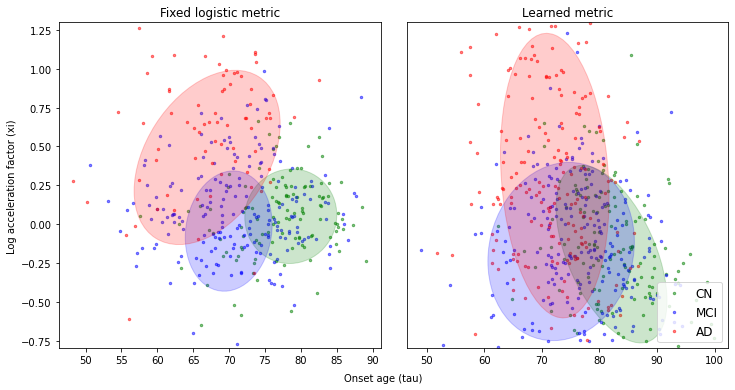

In [124]:
fig, axes = plt.subplots(1,2,figsize=(12, 6), gridspec_kw={'wspace':.08})

# Train the gmm on my parameters

X, y = ip[['tau', 'xi']].values, ip['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

estimator = GaussianMixture(n_components=n_classes, covariance_type='full', max_iter=200, random_state=0)

estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

# Train the other parameters using the EM algorithm.
estimator.fit(X_train)

h = axes[1]
make_ellipses(estimator, h)

for n, color in enumerate(colors):
    data = X_train[y_train == n]
    h.scatter(data[:, 0], data[:, 1], s=6, alpha=0.5, color=color,label=labels[n])

h.set_ylim([-.8,1.3])
h.get_yaxis().set_visible(False)
h.set_title('Learned metric')
    
# Train the gmm on leaspy parameters

X, y = individual_parameters[['tau', 'xi']].values, individual_parameters['label']
X[:,1] /= 1.8
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

estimator = GaussianMixture(n_components=n_classes, covariance_type='full', max_iter=200, random_state=0)

estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

# Train the other parameters using the EM algorithm.
estimator.fit(X_train)

h = axes[0]
make_ellipses(estimator, h)

for n, color in enumerate(colors):
    data = X_train[y_train == n]
    h.scatter(data[:, 0], data[:, 1], s=6, alpha=0.5, color=color,label=labels[n])

h.set_ylim([-.8,1.3])
h.set_ylabel('Log acceleration factor (xi)')
h.set_title('Fixed logistic metric')


fig.text(0.5, 0.05, 'Onset age (tau)', ha='center')
plt.xticks()
plt.yticks()

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))

plt.savefig('clustering.png', dpi=300)
plt.show()


<AxesSubplot:xlabel='tau', ylabel='xi'>

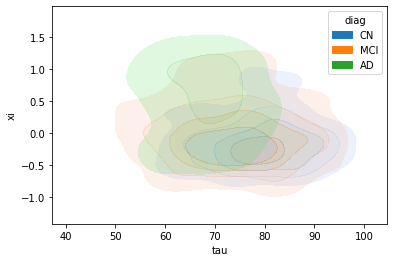

In [364]:
sns.kdeplot(data=ip, x='tau', y='xi', hue='diag', fill=True, alpha=0.2, levels=5)

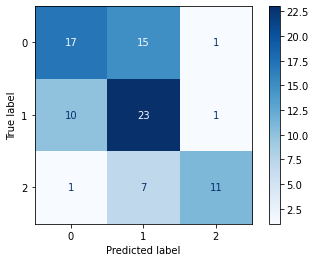

In [113]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_pred.astype(int), y_test.astype(int))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot(include_values=True, cmap=plt.cm.Blues, 
                 xticks_rotation=True)

plt.show()

In [217]:
y_test

array([0, 0, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 2, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 2, 1, 0, 0, 1, 0,
       1, 0, 2, 0, 0, 1, 2, 1, 1, 0, 2, 0, 2, 1, 1, 0, 0, 1, 0, 1, 2, 1,
       0, 2, 0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 0, 0])

## Geodesic visualization

In [6]:
study = 'simulated_study/'
output_folder = 'output_1/'

geodesic = pd.read_csv(study+output_folder+'LongitudinalMetricModel_reference_geodesic_trajectory_values.txt', sep=' ', header=None)
source_pos = pd.read_csv(study+output_folder+'LongitudinalMetricModel_source_0_pos_0.9.txt', sep=' ', header=None)
source_neg = pd.read_csv(study+output_folder+'LongitudinalMetricModel_source_0_neg_0.9.txt', sep=' ', header=None)

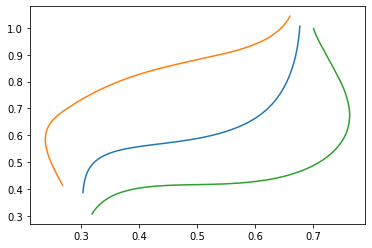

In [9]:
plt.plot(geodesic[0].values, geodesic[1].values)
plt.plot(source_pos[0].values, source_pos[1].values)
plt.plot(source_neg[0].values, source_neg[1].values)
plt.show()

## Plot the outputs for multivariate data

In [3]:
path = 'adni_study'
args = {'verbosity':'INFO', 'output':'personalize',
        'model':path+'/model_adni.xml', 'dataset':path+'/data_set.xml', 'parameters':path+'/optimization_parameters_saem.xml'}


"""
Read xml files, set general settings, and call the adapted function.
"""

xml_parameters = dfca.io.XmlParameters()
xml_parameters.read_all_xmls(args['model'],
                             args['dataset'],
                             args['parameters'])

logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logger.setLevel(logging.INFO)

In [4]:
dataset = read_and_create_scalar_dataset(xml_parameters)
model, individual_RER = instantiate_longitudinal_metric_model(xml_parameters, logger, dataset, observation_type='scalar')

286 good iterations out of 287
234 good iterations out of 235


In [5]:
spaceshifts = [-.8, -.5, -.2, 0, .2, .5, .8]

onset_ages = torch.tensor([70 for i in range(len(spaceshifts))])
log_accelerations = torch.tensor([0 for i in range(len(spaceshifts))])
sources = torch.tensor([[float(source)] for source in spaceshifts])

In [6]:
# Timepoints of visits

timepoints = [np.arange(50,95, 0.5) for i in range(len(onset_ages))]

In [7]:
v0, p0, metric_parameters, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
#onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(np.array(timepoints), log_accelerations, onset_ages)

absolute_times_to_write = []
for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

#np.savetxt(os.path.join(Settings().output_dir, "LongitudinalMetricModel_absolute_times.txt"), np.array(absolute_times_to_write))

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, metric_parameters,
                                            modulation_matrix)

160 good iterations out of 161
196 good iterations out of 197


In [8]:
predictions = []
subject_ids = []
times = []

for i in range(len(absolute_times)):
    predictions_i = []
    for j, t in enumerate(absolute_times[i]):
        prediction = model.spatiotemporal_reference_frame.get_position(t, sources=sources[i])
        predictions_i.append(prediction.cpu().data.numpy())
        subject_ids.append(i)
        times.append(absolute_times[i][j])
    predictions.append(predictions_i)

In [9]:
feat_1 = [[prediction[0] for prediction in predictions[i]] for i in range(len(predictions))]
feat_2 = [[prediction[1] for prediction in predictions[i]] for i in range(len(predictions))]
feat_3 = [[prediction[2] for prediction in predictions[i]] for i in range(len(predictions))]

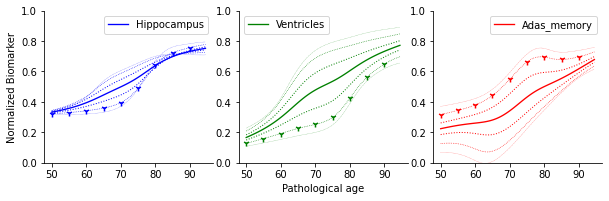

In [13]:
fig, axes = plt.subplots(1,3, figsize=(10,2.8), gridspec_kw={'wspace':0.15})

for i in range(len(spaceshifts)):
    if i == 3:
        axes[0].plot(timepoints[0],feat_1[i], color='b', linewidth=(4-abs(i-3))/3, label='Hippocampus')
        axes[1].plot(timepoints[0],feat_2[i], color='g', linewidth=(4-abs(i-3))/3, label='Ventricles')
        axes[2].plot(timepoints[0],feat_3[i], color='r', linewidth=(4-abs(i-3))/3, label='Adas_memory')
    else:
        axes[0].plot(timepoints[0],feat_1[i], color='b', linewidth=(4-abs(i-3))/3, linestyle='dotted')
        axes[1].plot(timepoints[0],feat_2[i], color='g', linewidth=(4-abs(i-3))/3, linestyle='dotted')
        axes[2].plot(timepoints[0],feat_3[i], color='r', linewidth=(4-abs(i-3))/3, linestyle='dotted')
    if i == 5:
        # Here we scatter some diamonds to see how a parallel curve acts on the features progression
        axes[0].scatter(timepoints[0][::10], feat_1[i][::10], color='b', marker='1')
        axes[1].scatter(timepoints[0][::10], feat_2[i][::10], color='g',  marker='1')
        axes[2].scatter(timepoints[0][::10], feat_3[i][::10], color='r', marker='1')

    axes[0].legend()
    axes[1].legend()
    axes[2].legend()

    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)   
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)   
    axes[2].spines['right'].set_visible(False)
    axes[2].spines['top'].set_visible(False)   

    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[2].set_ylim([0,1])
    
    axes[0].set_ylabel('Normalized Biomarker')
    axes[1].set_xlabel('Pathological age')

plt.savefig('adni.png', dpi=300, bbox_inches='tight')
plt.show()